In [720]:
%matplotlib inline
#imports needed for plotting and animation
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML


from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

Chunk below defines the 3D trajectory animation class:

In [721]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=150, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=3, alpha=1)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

Chunks below set up basic global parameters:

In [722]:
f = lambda x, y: -1*np.cos(x)*np.cos(y)*np.exp(-1*(x**2 * y**2))

In [723]:
Boundaries= [[-5,5,0.3],[-5,5,0.1]]

In [724]:
ParamSpcDims=2

In [725]:
StepSet = [-0.1,0.0,0.1]

Chunks below define functions which build up data necessary for animation and processing:

In [726]:
#generates data later to be used for surface plot
def Terrain(Boundaries):
    #bounds and spacing between sampled points
    xmin, xmax, xstep = Boundaries[0][0], Boundaries[0][1], Boundaries[0][2]
    ymin, ymax, ystep = Boundaries[1][0], Boundaries[1][1], Boundaries[1][2]
    
    #meshgrid bounded parameter space
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    
    #compute values on parameter space
    z = f(x, y)
    
    return x, y, z

In [727]:
def CreatePathNames(NumPaths):
    #set up path names
    path_iter = []
    path_base = "path"
    for i in range(0,NumPaths):
        path_name = path_base + "_" + str(i)
        path_iter.append(path_name)
    return path_iter


In [728]:
def AppendPathStart(path_iter, x0s):
    #add random (x,y) starting points to individual paths which are initially held as lists in a dict
    paths_ = defaultdict(list)
    iii=0
    for path in path_iter:
        paths_[path].append(x0s[:,iii])
        iii+=1
    return paths_

In [729]:
#create random initial coords for each of your N number of paths
def SnakePath_Start(NumPaths, StepSet, ParamSpcDims, Boundaries):
    # Define parameters for the walk
    #ParamSpcDims = 2
    #NumStepIter = 100
    #StepSet = [-0.1, 0, 0.1]
    xmin, xmax = Boundaries[0][0], Boundaries[0][1]
    ymin, ymax = Boundaries[1][0], Boundaries[1][1]
    #create random (x,y) starting points:
    #initialize empty list to place random (x,y) starting points
    x0s=[]
    #run for loop to append random (x,y) to list as numpy arrays
    for i in range(NumPaths):
        x0i = np.array([np.random.uniform(low=xmin, high=xmax), np.random.uniform(low=ymin, high=ymax)])
        #x0i = x0i.reshape((ParamSpcDims,1))
        print("this is x0" +str(i)+ ": " + str(x0i))
        x0s.append(x0i)
        #print(x0i)
    print("this is x0s:" +str(x0s))
    print("shape:"+str(np.shape(x0s)))
    x0s = np.array(x0s).T
    print("this is x0s (post T):" +str(x0s))
    print("shape:"+str(np.shape(x0s)))
    path_iter = CreatePathNames(NumPaths)
    paths_ = AppendPathStart(path_iter, x0s)
    
    return x0s, paths_, path_iter


In [730]:
#This is the Markov Chain portion of the MCMC, you are effectively only moving to a new coords
#iff it will decrease the z value
#try three small increment comparisons, if neither, take kamikazi leap for new position in parameter space
#it takes appx 7 seconds for 10,000 iterations of the function
#StepSet should be list of possible steps
#X0i should be 2X1 coords
#ParamSpcDims should be 2
#f should be function to be minimized
def SnakeChoice(paths_, StepSet, ParamSpcDims, f, path_i, index_i):
    CoordsPostChoice = np.zeros((1,ParamSpcDims))
    
    x0 = paths_['path_'+str(path_i)][index_i][0]
    print("this is x0:" +str(x0) + "\n")
    y0 = paths_['path_'+str(path_i)][index_i][1]
    print("this is y0:" +str(y0) + "\n")
    print("Initial (x,y)= (" + str(x0) + "," + str(y0) +")")
    #initial Z value at beginning of step choice sequence
    Zvalue0 = f(x0,y0)
    print("Initial Z value:" + str(Zvalue0))
    #random addition to x0, y0
    Plusx0 = np.random.choice(a=StepSet)
    Plusy0 = np.random.choice(a=StepSet)
    #ensures no (0,0) additions to (x,y)
    if Plusx0==0 and Plusy0==0:
        Plusy0 = np.random.choice(a=[StepSet[0], StepSet[2]])
    print("Plusx0: " + str(Plusx0))
    print("Plusy0: " + str(Plusy0))
    #potential new coords
    xn0 = x0+Plusx0
    yn0 = y0+Plusy0
    #check on boundary conditions (i.e. keep snakes on bounded space)
    if abs(xn0) > Boundaries[0][1]:
        xn0 = xn0 - 2*Plusx0
    if abs(yn0) > Boundaries[1][1]:
        yn0 = yn0 - 2*Plusy0
    #comparison Z value
    Zvalue_n0 = f(xn0,yn0)
    print("Z value from step attempt 1: " + str(Zvalue_n0) + ", with (x,y): (" + str(xn0) + "," + str(yn0) + ")")
    #round-off delta, will artificially increase Zvalue0 so that comparison has a better chance
    delta = 1e-15
    #test: Y: try another random step; N: new coords accepted bc new Z is less than original Z+delta
    if Zvalue0 + delta < Zvalue_n0:
        Plusx1 = np.random.choice(a=StepSet)
        Plusy1 = np.random.choice(a=StepSet)
        #ensures no (0,0) additions to (x,y)
        if Plusx1==0 and Plusy1==0:
            Plusy1 = np.random.choice(a=[StepSet[0], StepSet[2]])
        print("Plusx1: " + str(Plusx1))
        print("Plusy1: " + str(Plusy1))
        xn1 = x0 + Plusx1
        yn1 = y0 + Plusy1
        if abs(xn1) > Boundaries[0][1]:
            xn1 = xn1 - 2*Plusx1
        if abs(yn1) > Boundaries[1][1]:
            yn1 = yn1 - 2*Plusy1
        Zvalue_n1 = f(xn1,yn1)
        print("Z value from step attempt 2: " + str(Zvalue_n1) + ", with (x,y): (" + str(xn1) + "," + str(yn1) + ")")
        #test: Y: try another random step; N: return xn1, yn1
        if Zvalue0 + delta < Zvalue_n1:
            Plusx2 = np.random.choice(a=StepSet)
            Plusy2 = np.random.choice(a=StepSet)
            #ensures no (0,0) additions to (x,y)
            if Plusx2==0 and Plusy2==0:
                Plusy2 = np.random.choice(a=[StepSet[0], StepSet[2]])
            print(Plusx2)
            print(Plusy2)
            xn2 = x0 + Plusx2
            yn2 = y0 + Plusy2
            #arbitrary choice to send x back by 5*random x step
            if abs(xn2) > Boundaries[0][1]:
                xn2 = xn2 - 2*Plusx2
            if abs(yn2) > Boundaries[1][1]:
                yn2 = yn2 - 2*Plusy2
            Zvalue_n2 = f(xn2,yn2)
            print("Z value from step attempt 3: " + str(Zvalue_n2) + ", with (x,y): (" + str(xn2) + "," + str(yn2) + ")")
            #test: Y: no big jump attempt, N: return xn2, yn2
            if Zvalue0 + delta < Zvalue_n2:
                PlusBIGx = 10*np.random.choice(a=StepSet)
                PlusBIGy = 10*np.random.choice(a=StepSet)
                if PlusBIGx==0 and PlusBIGy==0:
                    PlusBIGy = 10*np.random.choice(a=[StepSet[0], StepSet[2]])
                print(PlusBIGx)
                print(PlusBIGy)
                xnBIG = x0 + PlusBIGx
                ynBIG = y0 + PlusBIGy
                #arbitrary choice to send x back by 2*random x step
                if abs(xnBIG) > Boundaries[0][1]:
                    xnBIG = xnBIG - 2*PlusBIGx
                if abs(ynBIG) > Boundaries[1][1]:
                   ynBIG = ynBIG - 2*PlusBIGy
                Zvalue_nBIG = f(xnBIG, ynBIG)
                print("Z value from BIG JUMP final attempt: " + str(Zvalue_nBIG) + ", with (x,y): (" + str(xnBIG) + "," + str(ynBIG) + ")")
                if Zvalue0 + delta < Zvalue_nBIG:
                    CoordsPostChoice[:,0]=x0
                    CoordsPostChoice[:,1]=y0
                    print("shape of coords: "+ str(np.shape(CoordsPostChoice)))
                    Zexit = np.asarray(Zvalue0).reshape((1,1))
                    paths_['path_'+str(path_i)]=np.vstack([paths_['path_'+str(path_i)],CoordsPostChoice])
                else:
                    CoordsPostChoice[:,0]=xnBIG
                    CoordsPostChoice[:,1]=ynBIG
                    print("shape of coords: "+str(np.shape(CoordsPostChoice)))
                    Zexit = np.asarray(Zvalue_nBIG).reshape((1,1))
                    paths_['path_'+str(path_i)]=np.vstack([paths_['path_'+str(path_i)],CoordsPostChoice])
            else:
                CoordsPostChoice[:,0]=xn2
                CoordsPostChoice[:,1]=yn2
                print("shape of coords: "+str(np.shape(CoordsPostChoice)))
                Zexit = np.asarray(Zvalue_n2).reshape((1,1))
                paths_['path_'+str(path_i)]=np.vstack([paths_['path_'+str(path_i)],CoordsPostChoice])
        else: 
            CoordsPostChoice[:,0]=xn1
            CoordsPostChoice[:,1]=yn1
            print("shape of coords: "+str(np.shape(CoordsPostChoice)))
            Zexit = np.asarray(Zvalue_n1).reshape((1,1))
            paths_['path_'+str(path_i)]=np.vstack([paths_['path_'+str(path_i)],CoordsPostChoice])
                         
    else:
        CoordsPostChoice[:,0]=xn0
        CoordsPostChoice[:,1]=yn0
        print("shape of coords: "+str(np.shape(CoordsPostChoice)))
        Zexit = np.asarray(Zvalue_n0).reshape((1,1))
        paths_['path_'+str(path_i)]=np.vstack([paths_['path_'+str(path_i)],CoordsPostChoice])
    #decided I wanted something more like 2X1 than 1X2 for CoordsPostChoice
    return CoordsPostChoice, Zexit, paths_['path_'+str(path_i)];
   

In [731]:
#current_coords should be one of the 2X1 entries of 'paths_'; for ex. paths_['path_i']
def CreateFullPath_i(Numberiterations, paths_, path_i):
    index_i=0
    BreakFlag=0
    Zvec = np.asarray(f(paths_['path_'+str(path_i)][index_i][0],paths_['path_'+str(path_i)][index_i][1])).reshape((1,1))
    current_coords = paths_['path_'+str(path_i)]
    while (BreakFlag==0) and (index_i<Numberiterations):
        compare_coords = current_coords
        current_coords, Zexit, paths_['path_'+str(path_i)] = SnakeChoice(paths_,step_set,dims,f,path_i, index_i)
        Zvec=np.vstack([Zvec,Zexit])
        print("this is Zvec: " + str(Zvec))
        if (-1e-10 < (Zvec[index_i]-Zvec[index_i+1]) < 1e-10):
            BreakFlag = 1
            print("Break condition met, negligible difference between consecutive Z values\n")
            print("Current Coords: "+ str(current_coords)+", Zexit: " + str(Zexit) + ", iterations performed: " +str(index_i) + "\n")
            if np.array_equal(compare_coords,current_coords) == 1:
                print("\n Break condition tripped by unchanged coords!")
        print("Difference in consecutive Z vals: " + str(Zvec[index_i]-Zvec[index_i+1]))
        index_i += 1
     
    return paths_['path_'+str(path_i)], Zvec

In [732]:
#function to create all i paths
def CreateAllPaths(NumPaths, StepSet, ParamSpcDims, Boundaries, NumberIterations):
    #set up initial random path coordinates
    x0s, paths_, path_iter = SnakePath_Start(NumPaths, StepSet=StepSet, ParamSpcDims=ParamSpcDims, Boundaries=Boundaries)
    ZvecTotal = []
    for path_i in range(0,NumPaths):
        paths_['path_'+str(path_i)], Zvec = CreateFullPath_i(NumberIterations, paths_, path_i)
        ZvecTotal.append(Zvec)
    return paths_, ZvecTotal, path_iter

Use above functions to generate MCMC trajectory data:

In [733]:
paths_, ZvecTotal, path_iter = CreateAllPaths(NumPaths=100, StepSet=StepSet, ParamSpcDims=ParamSpcDims, Boundaries=Boundaries, NumberIterations=30)

this is x00: [-4.89496875  3.44570702]
this is x01: [4.88041597 3.78372891]
this is x02: [-2.86535231  1.59103451]
this is x03: [3.24173762 0.67599185]
this is x04: [2.9346007  1.68803551]
this is x05: [-3.54753397 -1.02986022]
this is x06: [ 4.9261372  -4.64735562]
this is x07: [-2.55493865 -3.61282563]
this is x08: [-4.07374224  2.16803165]
this is x09: [-1.25888745 -4.35240923]
this is x010: [-1.6237948   1.94009023]
this is x011: [4.3308745  2.27062479]
this is x012: [-2.66967202 -0.18552005]
this is x013: [ 0.44352137 -0.06621125]
this is x014: [ 3.2623996  -3.83549943]
this is x015: [3.62456854 2.21004083]
this is x016: [-0.21447984 -0.83714269]
this is x017: [-1.7180132  -0.74765882]
this is x018: [0.64328625 1.80324442]
this is x019: [-2.67644448  4.54730917]
this is x020: [1.56377482 2.98437149]
this is x021: [-2.08306741 -1.07889413]
this is x022: [4.83757408 2.28180205]
this is x023: [-2.27831103  3.97390448]
this is x024: [-4.08964658 -0.84159942]
this is x025: [ 2.58638659

1.0
Z value from BIG JUMP final attempt: 0.0032030961294188245, with (x,y): (-2.2355995748896884,0.9688937108713969)
shape of coords: (1, 2)
this is Zvec: [[-0.32831049]
 [-0.32831049]]
Break condition met, negligible difference between consecutive Z values

Current Coords: [[-1.23559957 -0.03110629]], Zexit: [[-0.32831049]], iterations performed: 0


 Break condition tripped by unchanged coords!
Difference in consecutive Z vals: [0.]
this is x0:0.7206099195977531

this is y0:1.5397397227130156

Initial (x,y)= (0.7206099195977531,1.5397397227130156)
Initial Z value:-0.006812322526381398
Plusx0: 0.0
Plusy0: -0.1
Z value from step attempt 1: -0.03346718608279895, with (x,y): (0.7206099195977531,1.4397397227130155)
shape of coords: (1, 2)
this is Zvec: [[-0.00681232]
 [-0.03346719]]
Difference in consecutive Z vals: [0.02665486]
this is x0:0.7206099195977531

this is y0:1.4397397227130155

Initial (x,y)= (0.7206099195977531,1.4397397227130155)
Initial Z value:-0.03346718608279895
Plusx0: 

Initial (x,y)= (-4.531192360737723,-0.9242909010533116)
Initial Z value:2.6176247387003424e-09
Plusx0: 0.0
Plusy0: -0.1
Z value from step attempt 1: 4.133006460810061e-11, with (x,y): (-4.531192360737723,-1.0242909010533117)
shape of coords: (1, 2)
this is Zvec: [[4.36045992e-03]
 [5.75532908e-04]
 [2.89109496e-05]
 [7.36131858e-07]
 [3.02749712e-07]
 [2.61762474e-09]
 [4.13300646e-11]]
Difference in consecutive Z vals: [2.57629467e-09]
this is x0:-4.531192360737723

this is y0:-1.0242909010533117

Initial (x,y)= (-4.531192360737723,-1.0242909010533117)
Initial Z value:4.133006460810061e-11
Plusx0: 0.0
Plusy0: -0.1
Z value from step attempt 1: 4.168305951845628e-13, with (x,y): (-4.531192360737723,-1.1242909010533118)
shape of coords: (1, 2)
this is Zvec: [[4.36045992e-03]
 [5.75532908e-04]
 [2.89109496e-05]
 [7.36131858e-07]
 [3.02749712e-07]
 [2.61762474e-09]
 [4.13300646e-11]
 [4.16830595e-13]]
Break condition met, negligible difference between consecutive Z values

Current Coords: 

shape of coords: (1, 2)
this is Zvec: [[6.47687751e-04]
 [4.09411244e-04]
 [2.49563744e-04]
 [8.33160244e-05]]
Difference in consecutive Z vals: [0.00016625]
this is x0:1.1371204222072948

this is y0:2.5384036705608417

Initial (x,y)= (1.1371204222072948,2.5384036705608417)
Initial Z value:8.331602439054656e-05
Plusx0: -0.1
Plusy0: 0.1
Z value from step attempt 1: 0.0002495637438926725, with (x,y): (1.0371204222072947,2.638403670560842)
Plusx1: -0.1
Plusy1: 0.0
Z value from step attempt 2: 0.00040941124415953996, with (x,y): (1.0371204222072947,2.5384036705608417)
-0.1
0.1
Z value from step attempt 3: 0.0002495637438926725, with (x,y): (1.0371204222072947,2.638403670560842)
1.0
0.0
Z value from BIG JUMP final attempt: -7.316627871366694e-14, with (x,y): (2.137120422207295,2.5384036705608417)
shape of coords: (1, 2)
this is Zvec: [[ 6.47687751e-04]
 [ 4.09411244e-04]
 [ 2.49563744e-04]
 [ 8.33160244e-05]
 [-7.31662787e-14]]
Difference in consecutive Z vals: [8.33160245e-05]
this is x0:2

shape of coords: (1, 2)
this is Zvec: [[5.62789900e-04]
 [1.47395987e-04]
 [8.65363005e-05]
 [4.79280567e-05]]
Difference in consecutive Z vals: [3.86082439e-05]
this is x0:-2.326417024554701

this is y0:1.2474448802025155

Initial (x,y)= (-2.326417024554701,1.2474448802025155)
Initial Z value:4.792805665945029e-05
Plusx0: -0.1
Plusy0: 0.1
Z value from step attempt 1: 3.8103363589028555e-06, with (x,y): (-2.426417024554701,1.3474448802025156)
shape of coords: (1, 2)
this is Zvec: [[5.62789900e-04]
 [1.47395987e-04]
 [8.65363005e-05]
 [4.79280567e-05]
 [3.81033636e-06]]
Difference in consecutive Z vals: [4.41177203e-05]
this is x0:-2.426417024554701

this is y0:1.3474448802025156

Initial (x,y)= (-2.426417024554701,1.3474448802025156)
Initial Z value:3.8103363589028555e-06
Plusx0: 0.1
Plusy0: 0.1
Z value from step attempt 1: 1.0038911466624116e-06, with (x,y): (-2.326417024554701,1.4474448802025157)
shape of coords: (1, 2)
this is Zvec: [[5.62789900e-04]
 [1.47395987e-04]
 [8.65363005e-

Initial Z value:-0.8923103356184592
Plusx0: -0.1
Plusy0: -0.1
Z value from step attempt 1: -0.9053363126268857, with (x,y): (-0.2716871246722631,0.326329276924778)
shape of coords: (1, 2)
this is Zvec: [[-0.31830275]
 [-0.40810545]
 [-0.49474482]
 [-0.54321625]
 [-0.62064286]
 [-0.6476054 ]
 [-0.71504088]
 [-0.81608178]
 [-0.86540399]
 [-0.89231034]
 [-0.90533631]]
Difference in consecutive Z vals: [0.01302598]
this is x0:-0.2716871246722631

this is y0:0.326329276924778

Initial (x,y)= (-0.2716871246722631,0.326329276924778)
Initial Z value:-0.9053363126268857
Plusx0: 0.0
Plusy0: 0.1
Z value from step attempt 1: -0.8654039946406613, with (x,y): (-0.2716871246722631,0.42632927692477796)
Plusx1: -0.1
Plusy1: 0.0
Z value from step attempt 2: -0.8696562068665324, with (x,y): (-0.37168712467226306,0.326329276924778)
0.0
-0.1
Z value from step attempt 3: -0.9352088424066781, with (x,y): (-0.2716871246722631,0.22632927692477797)
shape of coords: (1, 2)
this is Zvec: [[-0.31830275]
 [-0.40810

Difference in consecutive Z vals: [0.00049044]
this is x0:-1.5157290976802305

this is y0:-1.1797458596125057

Initial (x,y)= (-1.5157290976802305,-1.1797458596125057)
Initial Z value:-0.0008572226938710668
Plusx0: 0.0
Plusy0: 0.1
Z value from step attempt 1: -0.0017822162238869425, with (x,y): (-1.5157290976802305,-1.0797458596125056)
shape of coords: (1, 2)
this is Zvec: [[-0.00036678]
 [-0.00085722]
 [-0.00178222]]
Difference in consecutive Z vals: [0.00092499]
this is x0:-1.5157290976802305

this is y0:-1.0797458596125056

Initial (x,y)= (-1.5157290976802305,-1.0797458596125056)
Initial Z value:-0.0017822162238869425
Plusx0: 0.0
Plusy0: 0.1
Z value from step attempt 1: -0.003380307014677498, with (x,y): (-1.5157290976802305,-0.9797458596125056)
shape of coords: (1, 2)
this is Zvec: [[-0.00036678]
 [-0.00085722]
 [-0.00178222]
 [-0.00338031]]
Difference in consecutive Z vals: [0.00159809]
this is x0:-1.5157290976802305

this is y0:-0.9797458596125056

Initial (x,y)= (-1.515729097680

In [734]:
#Transpose and make paths_ into numpy arrays
paths = [np.array(paths_[path]).T for path in path_iter]

In [735]:
#compute z values at each point along each path
zpaths = [f(*path) for path in paths]

In [736]:
#compute number of frames needed for animation based on max number of iterations taken amongst all path_i's
frames = max(path.shape[1] for path in paths)

In [737]:
frames

18

In [738]:
#NEED
#somethings for the plot
x,y,z=Terrain(Boundaries)

#to be used as a marker of the global minimum when plotting
minima = np.array([0.0, 0.0])
minima_ = minima.reshape(-1, 1)

The chunks below plot the figure and animate the trajectories:

No handles with labels found to put in legend.


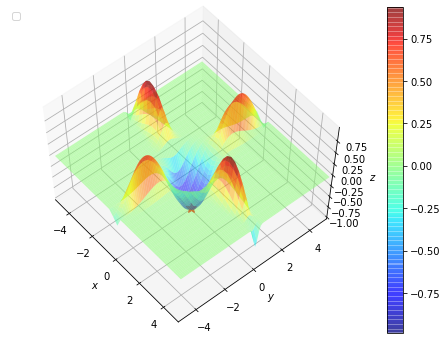

In [739]:
#set up figure
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d', elev=60, azim=-40)

#surface plot
surf=ax.plot_surface(x, y, z, rstride=1, cstride=1, edgecolor='none', alpha=.5, cmap=plt.cm.jet)
#plot of global min point with red star
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

#label axes
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

#set plotting bounds in xy plane
ax.set_xlim((Boundaries[0][0], Boundaries[0][1]))
ax.set_ylim((Boundaries[1][0], Boundaries[1][1]))

#animation of paths
#anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=paths_, ax=ax)
anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, ax=ax)
#add legend of path names and colorbar for surface height
ax.legend(loc='upper left')
fig.colorbar(surf)

In [741]:
#currently with steps size ±0.1
HTML(anim.to_html5_video())

In [742]:
icount=0
Zmins = []
for i in range(len(zpaths)):
    Zmins.append(min(zpaths[i]))
    if min(zpaths[i])<-0.8:
        print("min approached by path_" +str(i))
        icount+=1
minZ=min(Zmins)
minpos=Zmins.index(minZ)
print("\nnumber of close approaches: " +str(icount))
print("\nOptimal Z value found: " +str(min(Zmins))+ " with path_"+ str(minpos))

min approached by path_13
min approached by path_40
min approached by path_56
min approached by path_61
min approached by path_69
min approached by path_77
min approached by path_83
min approached by path_84
min approached by path_85
min approached by path_96

number of close approaches: 10

Optimal Z value found: -0.9982940058540317 with path_61


In [744]:
iterationstaken = []
for path in range(len(paths)):
    iterationstaken.append(len(paths[path][0]))
    #print("iterations taken for path_"+str(path)+": "+str(len(paths[path][0])))
avgitertaken = sum(iterationstaken)/len(paths)
print("average number of iterations needed to either find minimum or terminate path: "+str(avgitertaken))

average number of iterations needed to either find minimum or terminate path: 5.17


In [745]:
count=0
for path in range(len(paths)):
    if abs(paths[path][:,-1][0]) > 5 or abs(paths[path][:,-1][1])>5:
        print("path exceeded bounds, path_" +str(path))
    else:
        count+=1
if count == len(paths):
    print("No paths exceeded bounds.")

No paths exceeded bounds.
